In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**6.4.3 Семинар: Решаем задачу классификации на датасете CIFAR**

In [2]:
import torch
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets

In [4]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [5]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [6]:
len(y_train), len(y_test)

(50000, 10000)

In [7]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [8]:
X_train /= 255.
X_test /= 255.

In [9]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

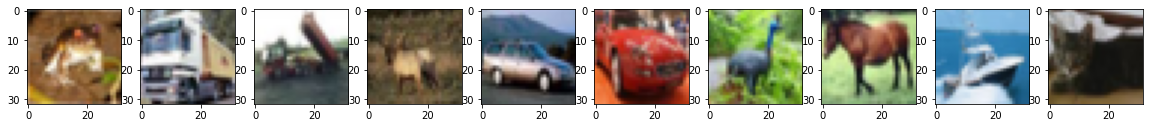

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [11]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [12]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)
X_train.shape

torch.Size([50000, 3, 32, 32])

In [13]:
#https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence/4529901
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as inp:
        return pickle.load(inp)

# sample usage
#company1 = [1,2,3,4,5]
#save_object(company1, '/kaggle/working/company1.pkl')
#del company
#company1 = load_object(filename)

In [14]:
def train(net, X_train, y_train, X_test, y_test, adam_params = {'lr': 1.0e-3}, batch_size = 100, epoch_num = 30):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), **adam_params)
    
    test_accuracy_history = []
    test_loss_history = []
    train_accuracy_history = []
    train_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(epoch_num):
        order = np.random.permutation(len(X_train))
        
        train_accuracy_epoch = []
        train_loss_epoch = []
    
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            
            #logging
            train_accuracy_epoch.append((preds.argmax(dim=1) == y_batch).float().mean().data.cpu())
            train_loss_epoch.append(loss_value.data.cpu())
            
            loss_value.backward()

            optimizer.step()
        
        net.eval()
        with torch.no_grad(): #не храним градиенты для теста, многоркатно сокращает потребление памяти
            test_preds = net.forward(X_test)
        
            #logging
            test_loss_history.append(loss(test_preds, y_test).data.cpu())
            train_loss_history.append(torch.stack(train_loss_epoch).float().mean().data.cpu())

            accuracy_test = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
            accuracy_train = torch.stack(train_accuracy_epoch).float().mean().data.cpu()
            test_accuracy_history.append(accuracy_test)
            train_accuracy_history.append(accuracy_train)

        print('Epoch = {:>3},     ACCURACY: test = {:.3f}, train = {:.3f},     LOSS: test = {:.3f}, train = {:.3f}'.format(epoch, 
                                                                                                                 accuracy_test, 
                                                                                                                 accuracy_train,
                                                                                                                 test_loss_history[-1],
                                                                                                                 train_loss_history[-1]))
    del net
    return test_accuracy_history, train_accuracy_history, test_loss_history, train_loss_history

accuracies = {}
losses = {}

In [15]:
# accuracies = load_object('/kaggle/working/accuracies_6_4_3.pkl')
# losses = load_object('/kaggle/working/losses_6_4_3.pkl')
# print(list(accuracies))
# print(list(losses))

In [16]:
def show_experiments_plots(accuracies, losses, figsize = (16.0, 6.0)):
    matplotlib.rcParams['figure.figsize'] = figsize
    
    for experiment_id in accuracies.keys():
        print('{:-<100}'.format(experiment_id))
        epoch_max_acc = np.array(accuracies[experiment_id]['test']).argmax()
        print('Max test accuracy on: Epoch = {:>3},     ACCURACY: test = {:.3f}, train = {:.3f},     LOSS: test = {:.3f}, train = {:.3f}'.format(epoch_max_acc, 
                                                                                                                 accuracies[experiment_id]['test'][epoch_max_acc], 
                                                                                                                 accuracies[experiment_id]['train'][epoch_max_acc],
                                                                                                                 losses[experiment_id]['test'][epoch_max_acc],
                                                                                                                 losses[experiment_id]['train'][epoch_max_acc]))
        epoch_min_loss = np.array(losses[experiment_id]['test']).argmin()
        print('Min test loss on:     Epoch = {:>3},     ACCURACY: test = {:.3f}, train = {:.3f},     LOSS: test = {:.3f}, train = {:.3f}'.format(epoch_min_loss, 
                                                                                                                 accuracies[experiment_id]['test'][epoch_min_loss], 
                                                                                                                 accuracies[experiment_id]['train'][epoch_min_loss],
                                                                                                                 losses[experiment_id]['test'][epoch_min_loss],
                                                                                                                 losses[experiment_id]['train'][epoch_min_loss]))
    
    for experiment_id in accuracies.keys():
        plt.plot(accuracies[experiment_id]['test'], label=experiment_id + ' test')
    plt.legend()
    plt.title('Validation Accuracy (Test only)')
    plt.show()

    for experiment_id in accuracies.keys():
        plt.plot(accuracies[experiment_id]['test'], label=experiment_id + ' test')
        plt.plot(accuracies[experiment_id]['train'], label=experiment_id + ' train')
    plt.legend()
    plt.title('Validation Accuracy (Test/Train)');
    plt.show()

    for experiment_id in losses.keys():
        plt.plot(losses[experiment_id]['test'], label=experiment_id  + ' test')
    plt.legend()
    plt.title('Validation Loss (Test only)');
    plt.show()

    for experiment_id in losses.keys():
        plt.plot(losses[experiment_id]['test'], label=experiment_id  + ' test')
        plt.plot(losses[experiment_id]['train'], label=experiment_id  + ' train')
    plt.legend()
    plt.title('Validation Loss (Test/Train)');
    plt.show()

In [17]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

In [18]:
net_name = 'cifar_net'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(CIFARNet(), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

Epoch =   0,     ACCURACY: test = 0.655, train = 0.589,     LOSS: test = 0.985, train = 1.167
Epoch =   1,     ACCURACY: test = 0.691, train = 0.711,     LOSS: test = 0.878, train = 0.824
Epoch =   2,     ACCURACY: test = 0.706, train = 0.763,     LOSS: test = 0.844, train = 0.677
Epoch =   3,     ACCURACY: test = 0.715, train = 0.804,     LOSS: test = 0.840, train = 0.563
Epoch =   4,     ACCURACY: test = 0.716, train = 0.840,     LOSS: test = 0.896, train = 0.460
Epoch =   5,     ACCURACY: test = 0.722, train = 0.870,     LOSS: test = 0.903, train = 0.374
Epoch =   6,     ACCURACY: test = 0.720, train = 0.894,     LOSS: test = 0.959, train = 0.304
Epoch =   7,     ACCURACY: test = 0.717, train = 0.914,     LOSS: test = 1.028, train = 0.250
Epoch =   8,     ACCURACY: test = 0.720, train = 0.927,     LOSS: test = 1.078, train = 0.206
Epoch =   9,     ACCURACY: test = 0.725, train = 0.935,     LOSS: test = 1.129, train = 0.184
Epoch =  10,     ACCURACY: test = 0.717, train = 0.940,     

In [19]:
from torchvision.models import resnet18

net_name = 'resnet18'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(resnet18(), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

Epoch =   0,     ACCURACY: test = 0.592, train = 0.511,     LOSS: test = 1.153, train = 1.388
Epoch =   1,     ACCURACY: test = 0.556, train = 0.656,     LOSS: test = 1.296, train = 0.974
Epoch =   2,     ACCURACY: test = 0.670, train = 0.718,     LOSS: test = 0.944, train = 0.804
Epoch =   3,     ACCURACY: test = 0.653, train = 0.758,     LOSS: test = 1.041, train = 0.688
Epoch =   4,     ACCURACY: test = 0.689, train = 0.799,     LOSS: test = 0.923, train = 0.579
Epoch =   5,     ACCURACY: test = 0.718, train = 0.828,     LOSS: test = 0.861, train = 0.491
Epoch =   6,     ACCURACY: test = 0.710, train = 0.856,     LOSS: test = 0.943, train = 0.410
Epoch =   7,     ACCURACY: test = 0.722, train = 0.883,     LOSS: test = 0.977, train = 0.332


KeyboardInterrupt: 

In [17]:
#my realization 2.1 (with custom norm/dropout)
class myResidualBlock_ResNet_Cifar(torch.nn.Module):
    def __init__(self, in_channels, out_channels, bias = True, batchnorm = True, dropout_p = None):
        super(myResidualBlock_ResNet_Cifar, self).__init__()
        
        list_general_sequential = []
        
        if in_channels == out_channels: #block without reduce image
            list_general_sequential.append(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=bias))

            if batchnorm:
                list_general_sequential.append(torch.nn.BatchNorm2d(out_channels))
            if not dropout_p is None:
                list_general_sequential.append(torch.nn.Dropout2d(dropout_p))
            
            list_general_sequential.append(torch.nn.ReLU())
            
            list_general_sequential.append(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=bias))
            
            if batchnorm:
                list_general_sequential.append(torch.nn.BatchNorm2d(out_channels))
            if not dropout_p is None:
                list_general_sequential.append(torch.nn.Dropout2d(dropout_p))
            
            self.shortcut = torch.nn.Sequential()
            
        else: #first block with reduce image
            list_general_sequential.append(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2, bias=bias))

            if batchnorm:
                list_general_sequential.append(torch.nn.BatchNorm2d(out_channels))
            if not dropout_p is None:
                list_general_sequential.append(torch.nn.Dropout2d(dropout_p))

            list_general_sequential.append(torch.nn.ReLU())
            
            list_general_sequential.append(torch.nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=bias))
            
            if batchnorm:
                list_general_sequential.append(torch.nn.BatchNorm2d(out_channels))
            if not dropout_p is None:
                list_general_sequential.append(torch.nn.Dropout2d(dropout_p))
            
            list_shortcut_sequential = []
            list_shortcut_sequential.append(torch.nn.Conv2d(in_channels, out_channels, 1, padding=0, stride=2, bias=bias))
            if batchnorm:
                list_shortcut_sequential.append(torch.nn.BatchNorm2d(out_channels))
            if not dropout_p is None:
                list_shortcut_sequential.append(torch.nn.Dropout2d(dropout_p))            
            self.shortcut = torch.nn.Sequential(*list_shortcut_sequential)
        
        self.general_sequential = torch.nn.Sequential(*list_general_sequential)
        self.act_finish = torch.nn.ReLU()
        
           
    def forward(self, x):
        out = self.general_sequential(x)
        out += self.shortcut(x)
        out = self.act_finish(out)
        
        return out
   
class myResNetСifar(torch.nn.Module):
    def __init__(self, num_repeat_layers = 3, bias = True, batchnorm = True, dropout_p = None):
        #num_repeat_layers = 3, 5, 7, 9 or 18, for 20, 32, 44, 56, 110-layers ResNet Сifar respectively
        
        super(myResNetСifar, self).__init__()
        
        #######Initial layer#######
        list_layer_init_sequential = []
        
        if batchnorm:
            list_layer_init_sequential.append(torch.nn.BatchNorm2d(3))
        if not dropout_p is None:
            list_layer_init_sequential.append(torch.nn.Dropout2d(dropout_p))
        
        list_layer_init_sequential.append(torch.nn.Conv2d(3, 16, 3, padding=1, bias=bias))
        
        if batchnorm:
            list_layer_init_sequential.append(torch.nn.BatchNorm2d(16))
        if not dropout_p is None:
            list_layer_init_sequential.append(torch.nn.Dropout2d(dropout_p))        
                                              
        list_layer_init_sequential.append(torch.nn.ReLU())
        
        self.layer_init = torch.nn.Sequential(*list_layer_init_sequential)
        
        #######Layer 1#######
        list_of_sequential_blocks = []
        for _ in range(num_repeat_layers):
            list_of_sequential_blocks.append(myResidualBlock_ResNet_Cifar(in_channels = 16, 
                                                                          out_channels = 16, bias = bias,
                                                                          batchnorm = batchnorm, dropout_p = dropout_p))
        self.layer_1 = torch.nn.Sequential(*list_of_sequential_blocks)
        
        #######Layer 2#######
        list_of_sequential_blocks = []
        list_of_sequential_blocks.append(myResidualBlock_ResNet_Cifar(in_channels = 16, 
                                                                      out_channels = 32, bias = bias,
                                                                          batchnorm = batchnorm, dropout_p = dropout_p)) #first block with reduce image
        for _ in range(num_repeat_layers - 1):
            list_of_sequential_blocks.append(myResidualBlock_ResNet_Cifar(in_channels = 32, 
                                                                          out_channels = 32, bias = bias,
                                                                          batchnorm = batchnorm, dropout_p = dropout_p))
        self.layer_2 = torch.nn.Sequential(*list_of_sequential_blocks)
        
        #######Layer 3#######
        list_of_sequential_blocks = []
        list_of_sequential_blocks.append(myResidualBlock_ResNet_Cifar(in_channels = 32, 
                                                                      out_channels = 64, bias = bias,
                                                                          batchnorm = batchnorm, dropout_p = dropout_p)) #first block with reduce image
        for _ in range(num_repeat_layers - 1):
            list_of_sequential_blocks.append(myResidualBlock_ResNet_Cifar(in_channels = 64, 
                                                                          out_channels = 64, bias = bias,
                                                                          batchnorm = batchnorm, dropout_p = dropout_p))
        self.layer_3 = torch.nn.Sequential(*list_of_sequential_blocks)
                                             
        #######Finishing layers#######
        self.layer_fin_pool = torch.nn.AvgPool2d(kernel_size=8)
        self.layer_fin_fc = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        x = self.layer_init(x)       
        
        x = self.layer_1(x)
        
        x = self.layer_2(x)
        
        x = self.layer_3(x)

        x = self.layer_fin_pool(x)
        x = torch.flatten(x, 1)
        x = self.layer_fin_fc(x)
              
        return x

In [ ]:
net_name = 'myResNet20'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_bsize_50'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3), X_train, y_train, X_test, y_test, batch_size = 50, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_bsize_300'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3), X_train, y_train, X_test, y_test, batch_size = 300, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_no_norm'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, batchnorm = False), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_dropout_0.1'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, dropout_p = 0.1), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_dropout_0.2'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, dropout_p = 0.2), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_dropout_0.5'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, dropout_p = 0.5), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_lr_3.0e-4'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3), X_train, y_train, X_test, y_test, adam_params = {'lr': 3.0e-4}, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_l2-reg_wc_1e-3'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3), X_train, y_train, X_test, y_test, adam_params = {'lr': 1.0e-3, 'weight_decay': 1e-3}, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_l2-reg_wc_1e-4'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3), X_train, y_train, X_test, y_test, adam_params = {'lr': 1.0e-3, 'weight_decay': 1e-4}, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet20_l2-reg_wc_1e-5'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3), X_train, y_train, X_test, y_test, adam_params = {'lr': 1.0e-3, 'weight_decay': 1e-5}, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet32'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(5), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet44'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(7), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet56'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(9), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
# show_experiments_plots(accuracies, losses)

In [ ]:
net_name = 'myResNet110'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(18), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
net_name = 'myResNet110_no_norm'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(18, batchnorm = False), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 20)

In [ ]:
save_object(accuracies, 'accuracies_6_4_3.pkl')
save_object(losses, 'losses_6_4_3.pkl')

In [ ]:
!ls

In [ ]:
show_experiments_plots(accuracies, losses)

## Mix of best models:

In [18]:
net_name = 'myResNet20_dropout_0.1_epoch_50'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, dropout_p = 0.1), X_train, y_train, X_test, y_test, batch_size = 100, epoch_num = 50)

Epoch =   0,     ACCURACY: test = 0.490, train = 0.348,     LOSS: test = 1.358, train = 1.751
Epoch =   1,     ACCURACY: test = 0.607, train = 0.501,     LOSS: test = 1.094, train = 1.383
Epoch =   2,     ACCURACY: test = 0.666, train = 0.579,     LOSS: test = 0.956, train = 1.184
Epoch =   3,     ACCURACY: test = 0.710, train = 0.625,     LOSS: test = 0.833, train = 1.057
Epoch =   4,     ACCURACY: test = 0.734, train = 0.661,     LOSS: test = 0.782, train = 0.972
Epoch =   5,     ACCURACY: test = 0.734, train = 0.687,     LOSS: test = 0.757, train = 0.898
Epoch =   6,     ACCURACY: test = 0.769, train = 0.711,     LOSS: test = 0.668, train = 0.835
Epoch =   7,     ACCURACY: test = 0.773, train = 0.726,     LOSS: test = 0.654, train = 0.789
Epoch =   8,     ACCURACY: test = 0.788, train = 0.737,     LOSS: test = 0.620, train = 0.760
Epoch =   9,     ACCURACY: test = 0.793, train = 0.749,     LOSS: test = 0.606, train = 0.725
Epoch =  10,     ACCURACY: test = 0.797, train = 0.761,     

In [19]:
net_name = 'myResNet20_dropout_0.1_bsize_50_epoch_50'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, dropout_p = 0.1), X_train, y_train, X_test, y_test, batch_size = 50, epoch_num = 50)

Epoch =   0,     ACCURACY: test = 0.489, train = 0.339,     LOSS: test = 1.404, train = 1.768
Epoch =   1,     ACCURACY: test = 0.611, train = 0.484,     LOSS: test = 1.109, train = 1.410
Epoch =   2,     ACCURACY: test = 0.678, train = 0.576,     LOSS: test = 0.918, train = 1.185
Epoch =   3,     ACCURACY: test = 0.713, train = 0.636,     LOSS: test = 0.822, train = 1.036
Epoch =   4,     ACCURACY: test = 0.733, train = 0.671,     LOSS: test = 0.757, train = 0.942
Epoch =   5,     ACCURACY: test = 0.765, train = 0.696,     LOSS: test = 0.678, train = 0.869
Epoch =   6,     ACCURACY: test = 0.769, train = 0.715,     LOSS: test = 0.660, train = 0.819
Epoch =   7,     ACCURACY: test = 0.785, train = 0.732,     LOSS: test = 0.623, train = 0.772
Epoch =   8,     ACCURACY: test = 0.792, train = 0.743,     LOSS: test = 0.596, train = 0.733
Epoch =   9,     ACCURACY: test = 0.800, train = 0.759,     LOSS: test = 0.574, train = 0.698
Epoch =  10,     ACCURACY: test = 0.802, train = 0.768,     

In [20]:
net_name = 'myResNet20_dropout_0.1_l2-reg_wc_1e-5_epoch_50'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, dropout_p = 0.1), X_train, y_train, X_test, y_test, adam_params = {'lr': 1.0e-3, 'weight_decay': 1e-5}, batch_size = 100, epoch_num = 50)

Epoch =   0,     ACCURACY: test = 0.456, train = 0.320,     LOSS: test = 1.467, train = 1.817
Epoch =   1,     ACCURACY: test = 0.572, train = 0.453,     LOSS: test = 1.197, train = 1.496
Epoch =   2,     ACCURACY: test = 0.633, train = 0.535,     LOSS: test = 1.040, train = 1.289
Epoch =   3,     ACCURACY: test = 0.681, train = 0.600,     LOSS: test = 0.908, train = 1.127
Epoch =   4,     ACCURACY: test = 0.709, train = 0.644,     LOSS: test = 0.831, train = 1.011
Epoch =   5,     ACCURACY: test = 0.735, train = 0.677,     LOSS: test = 0.761, train = 0.919
Epoch =   6,     ACCURACY: test = 0.760, train = 0.702,     LOSS: test = 0.694, train = 0.856
Epoch =   7,     ACCURACY: test = 0.777, train = 0.719,     LOSS: test = 0.638, train = 0.808
Epoch =   8,     ACCURACY: test = 0.780, train = 0.735,     LOSS: test = 0.644, train = 0.760
Epoch =   9,     ACCURACY: test = 0.792, train = 0.750,     LOSS: test = 0.599, train = 0.724
Epoch =  10,     ACCURACY: test = 0.798, train = 0.761,     

In [21]:
net_name = 'myResNet20_dropout_0.1_l2-reg_wc_1e-5_bsize_50_epoch_50'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, dropout_p = 0.1), X_train, y_train, X_test, y_test, adam_params = {'lr': 1.0e-3, 'weight_decay': 1e-5}, batch_size = 50, epoch_num = 50)

Epoch =   0,     ACCURACY: test = 0.539, train = 0.363,     LOSS: test = 1.288, train = 1.722
Epoch =   1,     ACCURACY: test = 0.619, train = 0.520,     LOSS: test = 1.065, train = 1.332
Epoch =   2,     ACCURACY: test = 0.684, train = 0.588,     LOSS: test = 0.902, train = 1.153
Epoch =   3,     ACCURACY: test = 0.721, train = 0.638,     LOSS: test = 0.801, train = 1.024
Epoch =   4,     ACCURACY: test = 0.749, train = 0.674,     LOSS: test = 0.736, train = 0.927
Epoch =   5,     ACCURACY: test = 0.764, train = 0.701,     LOSS: test = 0.684, train = 0.858
Epoch =   6,     ACCURACY: test = 0.777, train = 0.724,     LOSS: test = 0.644, train = 0.800
Epoch =   7,     ACCURACY: test = 0.795, train = 0.737,     LOSS: test = 0.611, train = 0.759
Epoch =   8,     ACCURACY: test = 0.795, train = 0.749,     LOSS: test = 0.590, train = 0.725
Epoch =   9,     ACCURACY: test = 0.804, train = 0.763,     LOSS: test = 0.575, train = 0.686
Epoch =  10,     ACCURACY: test = 0.800, train = 0.770,     

In [22]:
save_object(accuracies, 'accuracies_6_4_3_mix_best.pkl')
save_object(losses, 'losses_6_4_3_mix_best.pkl')

In [25]:
!ls

__notebook_source__.ipynb      cifar-10-python.tar.gz
accuracies_6_4_3_mix_best.pkl  losses_6_4_3_mix_best.pkl
cifar-10-batches-py


myResNet20_dropout_0.1_epoch_50---------------------------------------------------------------------
Max test accuracy on: Epoch =  47,     ACCURACY: test = 0.846, train = 0.879,     LOSS: test = 0.501, train = 0.345
Min test loss on:     Epoch =  30,     ACCURACY: test = 0.840, train = 0.853,     LOSS: test = 0.484, train = 0.427
myResNet20_dropout_0.1_bsize_50_epoch_50------------------------------------------------------------
Max test accuracy on: Epoch =  44,     ACCURACY: test = 0.846, train = 0.879,     LOSS: test = 0.492, train = 0.345
Min test loss on:     Epoch =  28,     ACCURACY: test = 0.838, train = 0.847,     LOSS: test = 0.480, train = 0.437
myResNet20_dropout_0.1_l2-reg_wc_1e-5_epoch_50------------------------------------------------------
Max test accuracy on: Epoch =  48,     ACCURACY: test = 0.847, train = 0.882,     LOSS: test = 0.480, train = 0.335
Min test loss on:     Epoch =  37,     ACCURACY: test = 0.845, train = 0.867,     LOSS: test = 0.472, train = 0.384
m

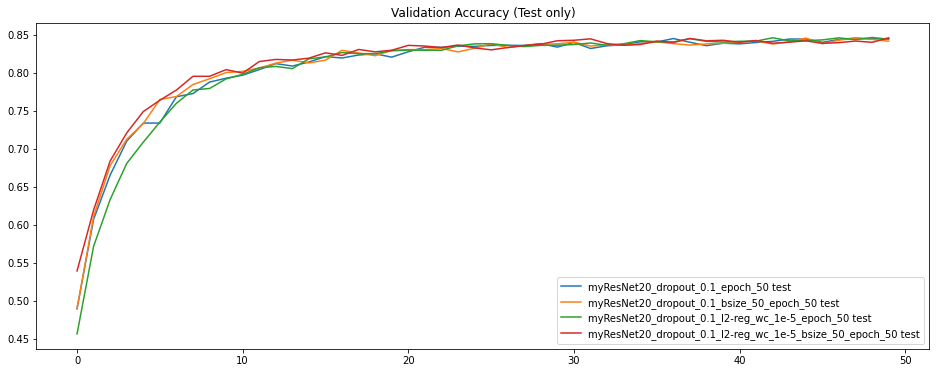

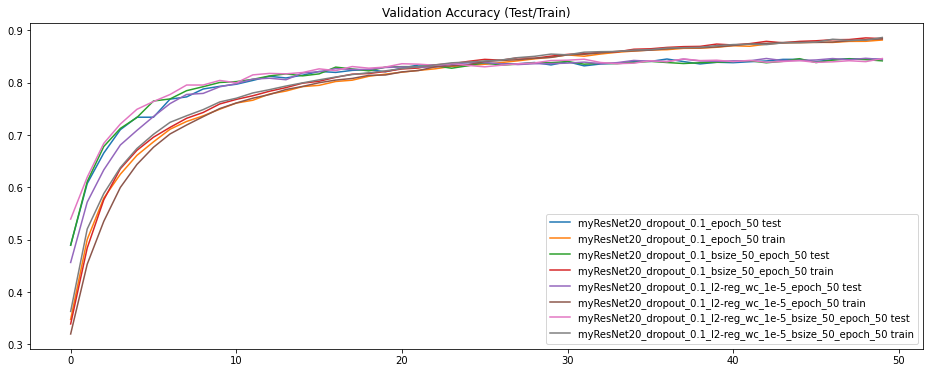

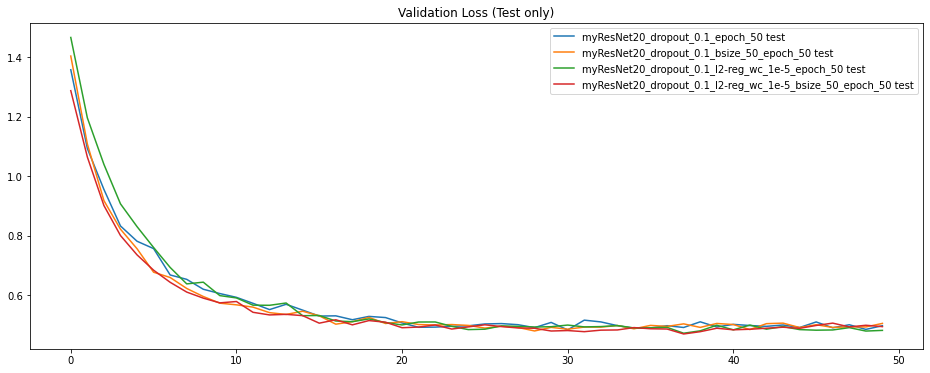

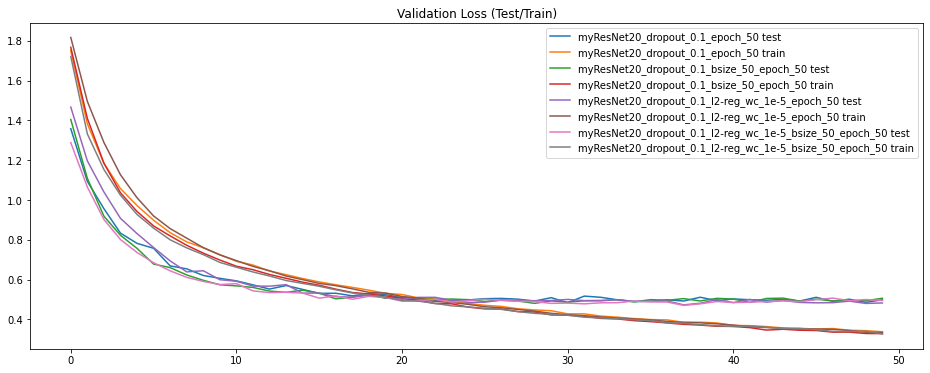

In [23]:
show_experiments_plots(accuracies, losses)

In [26]:
net_name = 'myResNet20_dropout_0.1_l2-reg_wc_1e-5_epoch_100'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(3, dropout_p = 0.1), X_train, y_train, X_test, y_test, adam_params = {'lr': 1.0e-3, 'weight_decay': 1e-5}, batch_size = 100, epoch_num = 100)

Epoch =   0,     ACCURACY: test = 0.496, train = 0.350,     LOSS: test = 1.355, train = 1.752
Epoch =   1,     ACCURACY: test = 0.632, train = 0.509,     LOSS: test = 1.039, train = 1.359
Epoch =   2,     ACCURACY: test = 0.672, train = 0.586,     LOSS: test = 0.938, train = 1.160
Epoch =   3,     ACCURACY: test = 0.706, train = 0.635,     LOSS: test = 0.845, train = 1.037
Epoch =   4,     ACCURACY: test = 0.716, train = 0.669,     LOSS: test = 0.801, train = 0.944
Epoch =   5,     ACCURACY: test = 0.752, train = 0.695,     LOSS: test = 0.716, train = 0.880
Epoch =   6,     ACCURACY: test = 0.776, train = 0.714,     LOSS: test = 0.658, train = 0.820
Epoch =   7,     ACCURACY: test = 0.782, train = 0.733,     LOSS: test = 0.636, train = 0.775
Epoch =   8,     ACCURACY: test = 0.791, train = 0.745,     LOSS: test = 0.612, train = 0.739
Epoch =   9,     ACCURACY: test = 0.793, train = 0.756,     LOSS: test = 0.605, train = 0.704
Epoch =  10,     ACCURACY: test = 0.805, train = 0.767,     

In [27]:
net_name = 'myResNet110_dropout_0.1_l2-reg_wc_1e-5_epoch_60'
accuracies[net_name] = {}
losses[net_name] = {}
accuracies[net_name]['test'], accuracies[net_name]['train'], losses[net_name]['test'],  losses[net_name]['train']= \
    train(myResNetСifar(18, dropout_p = 0.1), X_train, y_train, X_test, y_test, adam_params = {'lr': 1.0e-3, 'weight_decay': 1e-5}, batch_size = 100, epoch_num = 60)

Epoch =   0,     ACCURACY: test = 0.399, train = 0.253,     LOSS: test = 1.611, train = 2.019
Epoch =   1,     ACCURACY: test = 0.499, train = 0.410,     LOSS: test = 1.368, train = 1.608
Epoch =   2,     ACCURACY: test = 0.586, train = 0.518,     LOSS: test = 1.169, train = 1.347
Epoch =   3,     ACCURACY: test = 0.652, train = 0.600,     LOSS: test = 0.987, train = 1.142
Epoch =   4,     ACCURACY: test = 0.720, train = 0.650,     LOSS: test = 0.814, train = 1.001
Epoch =   5,     ACCURACY: test = 0.742, train = 0.691,     LOSS: test = 0.744, train = 0.892
Epoch =   6,     ACCURACY: test = 0.758, train = 0.713,     LOSS: test = 0.694, train = 0.825
Epoch =   7,     ACCURACY: test = 0.760, train = 0.733,     LOSS: test = 0.696, train = 0.768
Epoch =   8,     ACCURACY: test = 0.776, train = 0.753,     LOSS: test = 0.650, train = 0.710
Epoch =   9,     ACCURACY: test = 0.783, train = 0.773,     LOSS: test = 0.635, train = 0.660
Epoch =  10,     ACCURACY: test = 0.794, train = 0.784,     

In [30]:
save_object(accuracies, 'accuracies_6_4_3_mix_best2.pkl')
save_object(losses, 'losses_6_4_3_mix_best2.pkl')

myResNet20_dropout_0.1_epoch_50---------------------------------------------------------------------
Max test accuracy on: Epoch =  47,     ACCURACY: test = 0.846, train = 0.879,     LOSS: test = 0.501, train = 0.345
Min test loss on:     Epoch =  30,     ACCURACY: test = 0.840, train = 0.853,     LOSS: test = 0.484, train = 0.427
myResNet20_dropout_0.1_bsize_50_epoch_50------------------------------------------------------------
Max test accuracy on: Epoch =  44,     ACCURACY: test = 0.846, train = 0.879,     LOSS: test = 0.492, train = 0.345
Min test loss on:     Epoch =  28,     ACCURACY: test = 0.838, train = 0.847,     LOSS: test = 0.480, train = 0.437
myResNet20_dropout_0.1_l2-reg_wc_1e-5_epoch_50------------------------------------------------------
Max test accuracy on: Epoch =  48,     ACCURACY: test = 0.847, train = 0.882,     LOSS: test = 0.480, train = 0.335
Min test loss on:     Epoch =  37,     ACCURACY: test = 0.845, train = 0.867,     LOSS: test = 0.472, train = 0.384
m

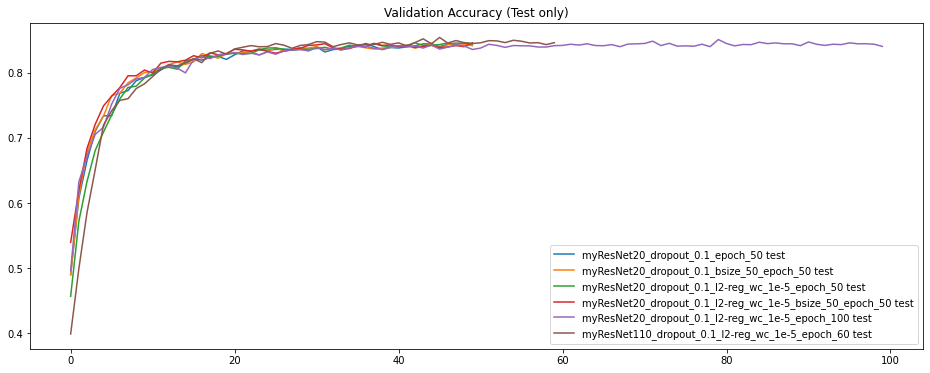

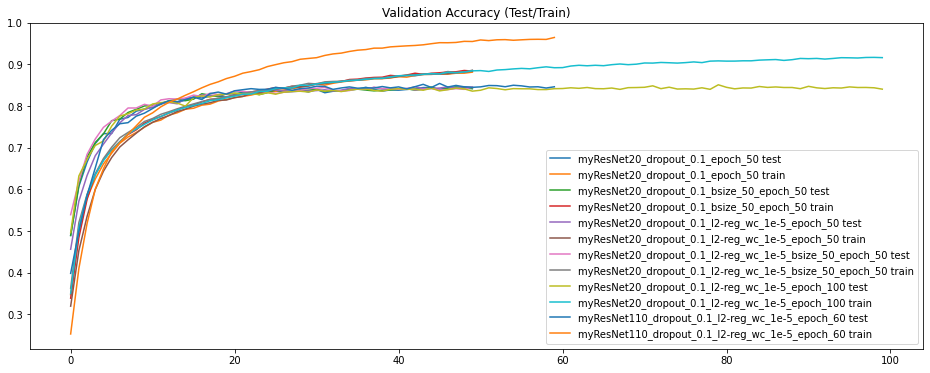

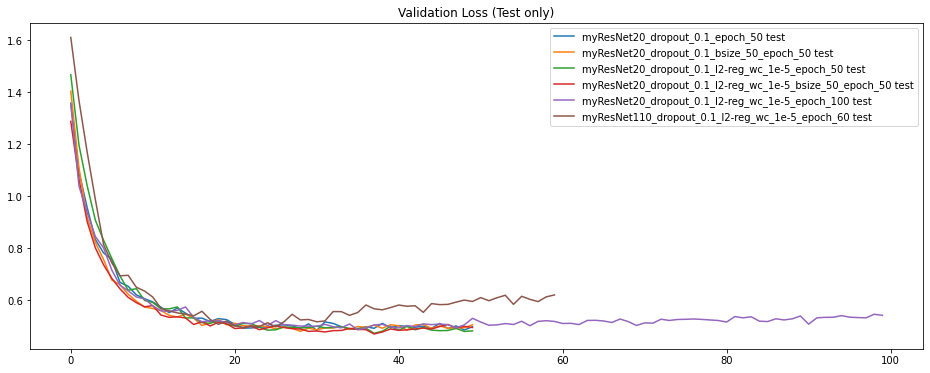

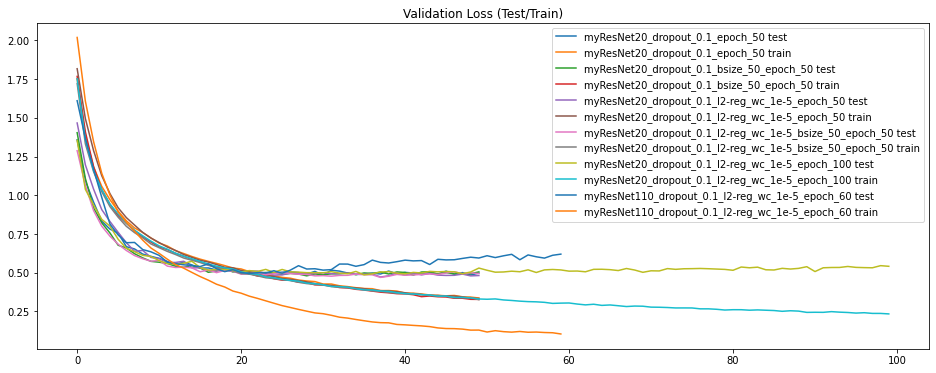

In [31]:
show_experiments_plots(accuracies, losses)

In [24]:
from time import sleep
sleep(10000000)

KeyboardInterrupt: 